In [1]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 10.8 MB/s eta 0:00:00


In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
import dask.array as da

In [34]:
from scipy.stats import chi2_contingency

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_sample = dd.read_csv('/content/drive/MyDrive/microsoft_projData/new_train_sample.csv', dtype={'ActionGranular': 'object',
       'ActionGrouped': 'object',
       'AntispamDirection': 'object',
       'ResourceType': 'object',
       'Roles': 'object',
       'ThreatFamily': 'object'})

In [5]:
# df_sample = df_sample.compute()

In [6]:
df_sample.head()

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,5172780,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,...,NaN,NaN,5,66,NaN,Suspicious,Malicious,242,1445,10630
1,8470561,927712939180,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,NaN,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,5897583,1090921697002,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1...,...,NaN,Destination,5,66,NaN,NaN,NaN,242,1445,10630
3,3288552,1434519079555,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,NaN,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,4060961,1005022347708,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,NaN,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [17]:
# shape of the data
df_sample.shape[0].compute(), df_sample.shape[1]


(4758418, 46)

In [7]:
df_sample.columns

Index(['Unnamed: 0', 'Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp',
       'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques',
       'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType',
       'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
       'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
       'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
       'RegistryValueName', 'RegistryValueData', 'ApplicationId',
       'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName',
       'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily',
       'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict',
       'CountryCode', 'State', 'City'],
      dtype='object')

In [19]:
df_sample = df_sample.drop(['Unnamed: 0'], axis=1 )

In [20]:
df_sample.shape[1]

45

In [21]:
df_sample.info()

<class 'dask_expr.DataFrame'>
Columns: 45 entries, Id to City
dtypes: float64(1), int64(30), string(14)

In [23]:
df_sample.describe().compute()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,...,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06,4.758418e+06
mean,8.425237e+11,1.815396e+02,7.066577e+04,4.062607e+05,1.105717e+02,2.945133e+03,9.566974e+04,1.287152e+05,2.857508e+05,1.503435e+05,...,3.342850e+03,8.807987e+02,2.622379e+05,1.076177e+05,3.583441e+03,4.898634e+00,6.465691e+01,2.236922e+02,1.351550e+03,9.936695e+03
std,4.962194e+11,3.868571e+02,1.208436e+05,4.590474e+05,4.345897e+02,1.145625e+04,1.633971e+04,3.399745e+04,1.412268e+05,3.748440e+04,...,5.101700e+02,1.282564e+01,8.155180e+04,3.220588e+04,9.093033e+01,7.031900e-01,9.310489e+00,6.276881e+01,3.508813e+02,2.605943e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,1.000000e+01,5.100000e+02,2.371000e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.047300e+04,2.178915e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.720000e+02,8.490225e+04,6.736865e+05,4.600000e+01,1.830000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997030e+05,1.721456e+06,9.522000e+03,1.131730e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [25]:
df_sample.isnull().sum().compute()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,2733136
IncidentGrade,25775


In [7]:
df_sample = df_sample.drop(['MitreTechniques','ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType','Roles','AntispamDirection','SuspicionLevel','LastVerdict'], axis=1)

In [33]:
df_sample = df_sample.drop(['Id'], axis=1)

In [8]:
df_sample = df_sample.dropna(subset=['IncidentGrade'])

In [29]:
df_sample.isnull().sum().compute()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,0
EntityType,0


In [30]:
df_sample.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [9]:
column_to_move = 'IncidentGrade'
new_order = [col for col in df_sample.columns if col != column_to_move] + [column_to_move]
df_sample = df_sample[new_order]

In [32]:
df_sample.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,IncidentGrade
0,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,File,Related,...,881,4132,4227,3586,5,66,242,1445,10630,BenignPositive
1,927712939180,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,Machine,Impacted,...,881,289573,117668,3586,5,66,242,1445,10630,BenignPositive
2,1090921697002,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,Machine,Impacted,...,881,289573,117668,3586,5,66,242,1445,10630,BenignPositive
3,1434519079555,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,File,Related,...,881,97007,9177,3586,5,66,242,1445,10630,TruePositive
4,1005022347708,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,File,Impacted,...,881,39978,114449,3586,5,66,242,1445,10630,BenignPositive


## EDA

In [11]:
df_sample.info()

<class 'dask_expr.DataFrame'>
Columns: 36 entries, Unnamed: 0 to IncidentGrade
dtypes: int64(31), string(5)

In [12]:
cate_cols = df_sample.select_dtypes(include=['string']).columns
cate_cols

Index(['Timestamp', 'Category', 'EntityType', 'EvidenceRole', 'IncidentGrade'], dtype='object')

In [15]:
cat_col_counts = df_sample['Category'].value_counts().compute()

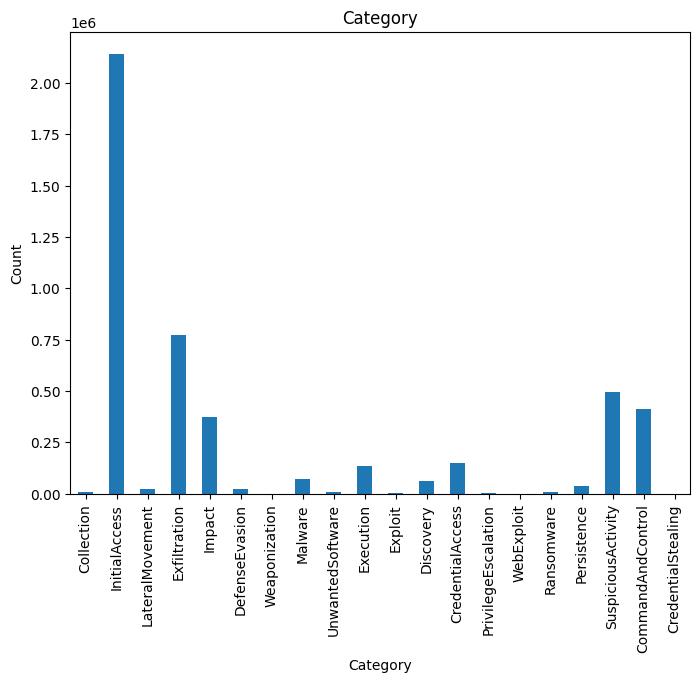

In [16]:
# fig, axes = plt.subplots(nrows=len(cate_cols), ncols=1, figsize=(8, len(cate_cols) * 4))

fig, ax = plt.subplots(figsize=(8, 6))

cat_col_counts.plot(kind='bar',title='Category')
ax.set_ylabel('Count')

plt.show()

In [21]:
df_sample['Timestamp'].head(1)[0]

'2024-06-06T05:56:47.000Z'

In [23]:
df_sample['Timestamp'] = df_sample['Timestamp'].str.extract(r'(\d{4}-\d{2}-\d{2})', expand=False)

In [25]:
df_sample['Timestamp'] = dd.to_datetime(df_sample['Timestamp'], format='%Y-%m-%d')

In [26]:
df_sample.info()

<class 'dask_expr.DataFrame'>
Columns: 36 entries, Unnamed: 0 to IncidentGrade
dtypes: datetime64[ns](1), int64(31), string(4)

In [27]:
EntityType_counts = df_sample['EntityType'].value_counts().compute()

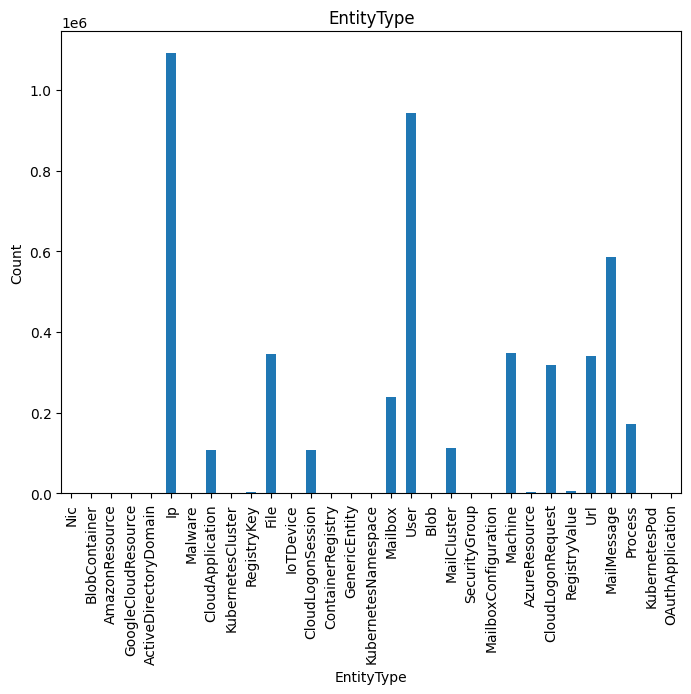

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

EntityType_counts.plot(kind='bar',title='EntityType')
ax.set_ylabel('Count')

plt.show()

In [29]:
EvidenceRole_counts = df_sample['EvidenceRole'].value_counts().compute()

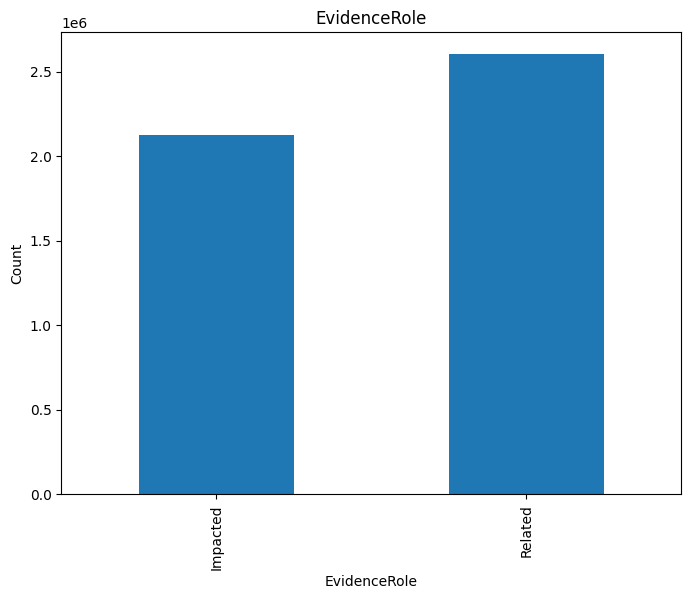

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

EvidenceRole_counts.plot(kind='bar',title='EvidenceRole')
ax.set_ylabel('Count')

plt.show()

In [31]:
IncidentGradev_counts = df_sample['IncidentGrade'].value_counts().compute()

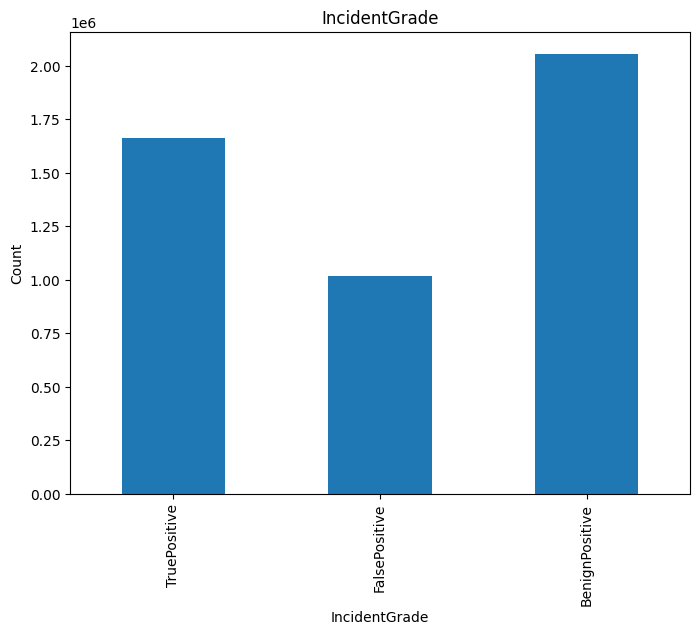

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

IncidentGradev_counts.plot(kind='bar',title='IncidentGrade')
ax.set_ylabel('Count')

plt.show()

In [46]:
cat_grouped = df_sample.groupby(['Category', 'IncidentGrade']).size().compute().values

total_len = len(df_sample)
print(total_len)

4732643


In [47]:
from dask.array.stats import chisquare

In [49]:
expected = [total_len / len(cat_grouped)] * len(cat_grouped)

# perform chi-square test
chi2_stat, p_value = chisquare(da.from_array(cat_grouped), f_exp=da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat.compute():.6f}")
print(f"P-value: {p_value.compute():.6f}")

Chi-square statistic: 23977532.833118
P-value: 0.000000


## - so it is evident that the p-value is less than 0.05, which means there is a significant correlation between the two variables

In [50]:
entity_grouped = df_sample.groupby(['EntityType', 'IncidentGrade']).size().compute().values

In [51]:
expected = [total_len / len(entity_grouped)] * len(entity_grouped)

# perform chi-square test
chi2_stat, p_value = chisquare(da.from_array(entity_grouped), f_exp=da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat.compute():.6f}")
print(f"P-value: {p_value.compute():.6f}")

Chi-square statistic: 14803971.864897
P-value: 0.000000


there is a significant correlation between the two variables



In [52]:
Evidence_grouped = df_sample.groupby(['EvidenceRole', 'IncidentGrade']).size().compute().values

In [53]:
expected = [total_len / len(Evidence_grouped)] * len(Evidence_grouped)

# perform chi-square test
chi2_stat, p_value = chisquare(da.from_array(Evidence_grouped), f_exp=da.from_array(expected))

print(f"Chi-square statistic: {chi2_stat.compute():.6f}")
print(f"P-value: {p_value.compute():.6f}")

Chi-square statistic: 526271.262938
P-value: 0.000000


there is a significant correlation between the two variables

In [56]:
df_sample.select_dtypes(include=['int64']).columns

Index(['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [55]:
df_sample = df_sample.drop(['Unnamed: 0'], axis=1)

In [59]:
rangev = [df_sample['State'].min().compute(), df_sample['State'].max().compute()]

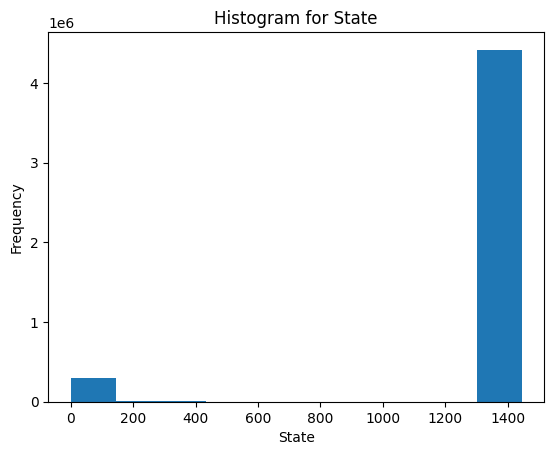

In [60]:
# Compute the histogram
hist, bin_edges = da.histogram(df_sample['State'].values, bins=10, range=rangev)

# Compute the histogram values
hist_values = hist.compute()

# Plot the histogram
plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()

In [61]:
rangev = [df_sample['NetworkMessageId'].min().compute(), df_sample['NetworkMessageId'].max().compute()]

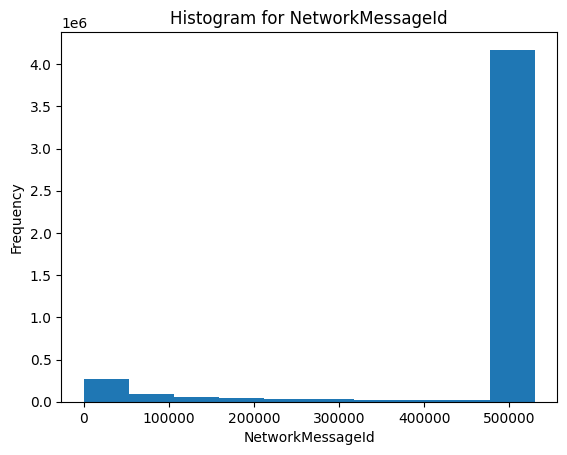

In [62]:
hist, bin_edges = da.histogram(df_sample['NetworkMessageId'].values, bins=10, range=rangev)

# Compute the histogram values
hist_values = hist.compute()

plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for NetworkMessageId')
plt.xlabel('NetworkMessageId')
plt.ylabel('Frequency')
plt.show()

In [63]:
rangev = [df_sample['CountryCode'].min().compute(), df_sample['CountryCode'].max().compute()]

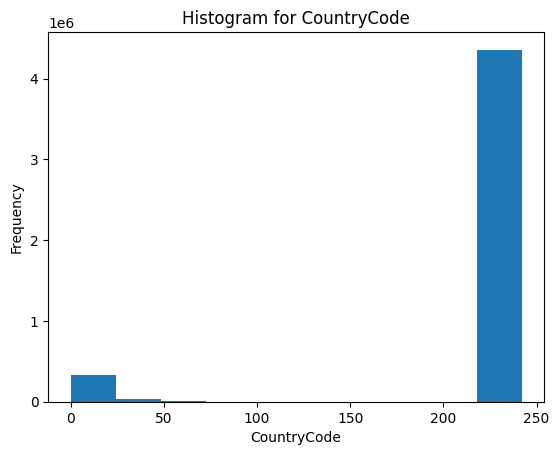

In [64]:
hist, bin_edges = da.histogram(df_sample['CountryCode'].values, bins=10, range=rangev)

# Compute the histogram values
hist_values = hist.compute()

plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for CountryCode')
plt.xlabel('CountryCode')
plt.ylabel('Frequency')
plt.show()

In [65]:
rangev = [df_sample['AlertTitle'].min().compute(), df_sample['AlertTitle'].max().compute()]

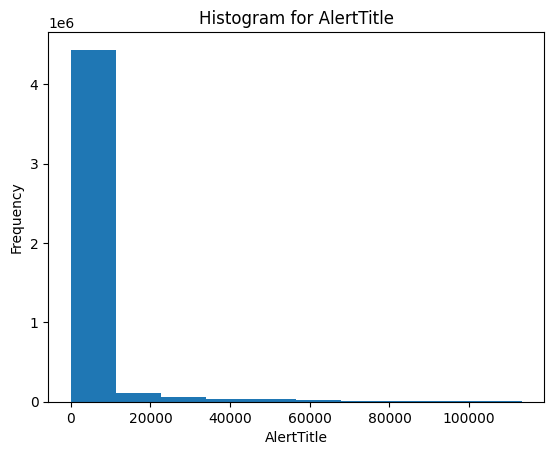

In [66]:
hist, bin_edges = da.histogram(df_sample['AlertTitle'].values, bins=10, range=rangev)

# Compute the histogram values
hist_values = hist.compute()

plt.figure()
plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
plt.title(f'Histogram for AlertTitle')
plt.xlabel('AlertTitle')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# for column in df_sample.select_dtypes(include=['int64']).columns:
#     # Compute the histogram
#     hist, bin_edges = da.histogram(df_sample[column].values, bins=10)

#     # Compute the histogram values
#     hist_values = hist.compute()

#     # Plot the histogram
#     plt.figure()
#     plt.hist(bin_edges[:-1], bin_edges, weights=hist_values)
#     plt.title(f'Histogram for {column}')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.show()

